In [1]:
import torch
import torch.nn as nn
import random
import itertools
import os
import networkx as nx
import matplotlib.pyplot as plt
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_keys):
        super(Model, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_keys)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, :, :])
        return out

In [3]:
class workflow_constructor:
    def __init__(self,model,input_size=1,ts=0.005,num_candidates=10):

        self.softmax = nn.Softmax(dim=0)
        self.model = model
        self.input_size = input_size
        self.visited = set()
        self.graph = dict()
        self.ts = ts
        self.num_candidates=10

    def permutation(self,event_list):
        return [list(event) for event in (itertools.permutations(event_list))]

    def generate_seq(self,start, window_size=10, scope=None):
        if isinstance(start, list):
            start = torch.FloatTensor(start).reshape(1, -1)
        bg = start.size(1)
        if scope == None:
            scope = self.num_candidates
        for i in range(bg, bg + window_size):
            seq = start.clone().detach().view(-1, i, self.input_size).to(device)
            output = model(seq).cpu()[:, -1, :]
            output = output.reshape(-1)
            predicted = torch.argsort(output)[-self.num_candidates:]
            nxt = random.randint(1, scope)
            start = torch.cat([start, predicted[-nxt].reshape(1, -1).float()], 1)
        return start, predicted, output

    def predict_next_event(self,seq):
        _, predicted, output = self.generate_seq(seq, 1)
        prob = self.softmax(output)
        scope = 0
        for i in range(self.num_candidates):
            if prob[predicted[self.num_candidates - i - 1]] < self.ts:
                scope = self.num_candidates - i - 1
                break
        return predicted[scope + 1:].cpu().numpy().tolist()

    def next_possible_event(self,seq,out_of_order=False, bg=0, ed=-1):
        res = []
        if not out_of_order:
            res.extend(self.predict_next_event(seq))
        else:
            seq_list = self.permutation(seq[bg:ed])
            for s in seq_list:
                res.extend(self.predict_next_event(s + seq[ed:]))
            res = list(set(res))
        return res

    def is_connected(self,e1, e2, eventmap):
        eventList = list(eventmap.keys())
        visited = {i: False for i in eventList}
        que = []
        que.append(e1)
        while len(que) != 0:
            cur = que.pop(0)
            visited[cur] = True
            if e2 in eventmap[cur]:
                return True
            for e in eventmap[cur]:
                if e in eventList and not visited[e]:
                    que.append(e)
        return False

    def recognize_branch(self,next_event):
        concurrent_group = []
        if 30 in next_event:
            next_event.remove(30)
        event_to_group = [-1 for _ in next_event]
        event_to_next = {event: self.next_possible_event([event]) for event in next_event}
        for i, event in enumerate(next_event):
            if event_to_group[i] == -1:
                cur_group = [event]
                concurrent_group.append(cur_group)
                event_to_group[i] = len(concurrent_group) - 1
            for j, event2 in enumerate(next_event[i + 1:]):
                if self.is_connected(event, event2, event_to_next) and self.is_connected(event2, event, event_to_next):
                    if event_to_group[j + i + 1] == -1:
                        event_to_group[j + i + 1] = event_to_group[i]
                        concurrent_group[event_to_group[i]].append(event2)
        #                 print(concurrent_group,i,j+i+1)
        return concurrent_group

    def recognize_loop(self,seq, concurrent_event):

        next_event = self.next_possible_event(seq)
        for event in next_event:
            if event in seq and event not in concurrent_event:
                if self.find_loop(seq[seq.index(event):]):
                    return seq[seq.index(event):]
        return []

    def find_loop(self,seq):

        loop_len = len(seq)
        loop_seq = [event for event in seq]
        for i in range(loop_len):
            if loop_seq[i] not in self.next_possible_event(loop_seq):
                return False
            loop_seq.append(loop_seq[i])
        return True

    def add_line(self,begin,end,concurrent):
        if concurrent:
            begin = 'merge({})'.format(','.join(list(map(str,sorted(begin)))))
        else:
            begin = str(begin[-1])
        if begin not in self.graph:
            self.graph[begin] = set()
        if len(end)>1:
            end_mark = ','.join(list(map(str,sorted(end))))
            self.graph[begin].add('diverge({})'.format(end_mark))
            if 'diverge({})'.format(end_mark) not in self.graph:
                self.graph['diverge({})'.format(end_mark)] =set()
            for event in end:
                self.graph['diverge({})'.format(end_mark)].add(str(event))
                if str(event) not in self.graph:
                    self.graph[str(event)] = set()
                self.graph[str(event)].add('merge({})'.format(end_mark))
        else:
            self.graph[begin].add(str(end[0]))

    def workflow_construction(self,seq=[0], end={30}, visited = None,concurrent=False):
        next_event = self.next_possible_event(seq, out_of_order=concurrent, ed=len(seq))
        if visited==None:
            visited = set()
        for event in next_event[::-1]:
            if event in seq or event in visited:
                next_event.remove(event)
        print("当前序列为:", seq, "下一个可能出现event为:", next_event)
        for event in seq:
            visited.add(event)
            
        if set(next_event) == end or set(next_event).issubset(end):
            print("到达终止位置,结束", end)
            if len(next_event)>0:
                self.add_line(seq,next_event,concurrent)
            return seq
        
        if not concurrent:
            loop = self.recognize_loop(seq, [])
            if len(loop) != 0:
                print("当前序列中存在循环结构", loop)
                self.add_line([loop[0]],[loop[-1]],False)

        print("判断分支情况", next_event)
        if len(next_event) >= 2:
            concorrent_group = self.recognize_branch(next_event)
        else:
            concorrent_group = [[next_event[0]]]
        print("发现不同的分支", concorrent_group)

        for group in concorrent_group:
            self.add_line(seq,group,concurrent)
            if len(group) >= 2:
                print("并发执行的分支", group)
                for i, event in enumerate(group):
                    loop = self.recognize_loop([event], group[:i] + group[i + 1:])
                    if len(loop) != 0:
                        print("发现循环", loop)
                        self.add_line([event],[event],False)
                self.workflow_construction(group, end, visited, True)
            else:
                self.workflow_construction(group, {30},visited)
        return seq

In [4]:
def draw_wf(wf_cons):
    g = nx.DiGraph()
    graph = wf_cons.graph

    g.add_nodes_from(list(graph.keys()))
    pos = {}
    h = 0
    for i,key in enumerate(graph.keys()):
        for j,node in enumerate(list(graph[key])):
            g.add_edge(key,node)
    height = {}
    width = {}
    shortest_path = dict(nx.all_pairs_shortest_path(g))
    for key in shortest_path:
    #     if key=='0':
    #         height['0']=0
    #         continue
        height[key] = len(shortest_path['0'][key])
        if height[key] not in width:
            width[height[key]] = 0
        width[height[key]]+=1
    width_cur = {i:0 for i in list(width.keys())}
    for i,key in enumerate(graph.keys()):
        if key not in pos:
            pos[key] = (0,height[key])
        for j,node in enumerate(list(graph[key])):
            if node not in pos:

                if width[height[node]]%2==0:
                    pos[node] = (width_cur[height[node]]+0.5-(width[height[node]]/2),height[node])
                else:
                    pos[node] = (width_cur[height[node]]-int(width[height[node]]/2),height[node])
                width_cur[height[node]] += 1
                print(j,width[height[node]],pos[node])
    pos['30'] = (0,len(width)+1)
    # layout = nx.spring_layout(g,  pos=pos)
    nx.draw(g,pos=pos,with_labels=True)
    plt.draw()
    plt.show()

In [5]:
num_classes = 32
num_epochs = 300
batch_size = 2048
input_size = 1
model_dir = 'model'
window_size = 10
log = 'add_padding_batch_size={}_epoch={}_window_size={}'.format(str(batch_size), str(num_epochs), str(window_size))
num_layers = 2
hidden_size = 64
file_dir = 'data/'
model = Model(input_size, hidden_size, num_layers, num_classes).to(device)
model.load_state_dict(torch.load(model_dir + '/' + log + '.pt'))
model.to(device)
model.eval()

Model(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=32, bias=True)
)

In [6]:
wf_cons = workflow_constructor(model,1)
wf_cons.workflow_construction([0],{30})
print(wf_cons.graph)

当前序列为: [0] 下一个可能出现event为: [22, 5]
判断分支情况 [22, 5]
发现不同的分支 [[22, 5]]
并发执行的分支 [22, 5]
发现循环 [5]
当前序列为: [22, 5] 下一个可能出现event为: [9, 26, 11]
判断分支情况 [9, 26, 11]
发现不同的分支 [[9, 26, 11]]
并发执行的分支 [9, 26, 11]
发现循环 [9]
发现循环 [26]
发现循环 [11]
当前序列为: [9, 26, 11] 下一个可能出现event为: [2, 3, 4, 23, 30]
判断分支情况 [2, 3, 4, 23, 30]
发现不同的分支 [[2, 3, 4], [23]]
并发执行的分支 [2, 3, 4]
发现循环 [2]
发现循环 [3]
发现循环 [4]
当前序列为: [2, 3, 4] 下一个可能出现event为: [23]
判断分支情况 [23]
发现不同的分支 [[23]]
当前序列为: [23] 下一个可能出现event为: [21]
当前序列中存在循环结构 [23]
判断分支情况 [21]
发现不同的分支 [[21]]
当前序列为: [21] 下一个可能出现event为: [30]
到达终止位置,结束 {30}
当前序列为: [23] 下一个可能出现event为: []
到达终止位置,结束 {30}
{'0': {'diverge(5,22)'}, 'diverge(5,22)': {'5', '22'}, '22': {'merge(5,22)'}, '5': {'5', 'merge(5,22)'}, 'merge(5,22)': {'diverge(9,11,26)'}, 'diverge(9,11,26)': {'26', '9', '11'}, '9': {'9', 'merge(9,11,26)'}, '26': {'26', 'merge(9,11,26)'}, '11': {'11', 'merge(9,11,26)'}, 'merge(9,11,26)': {'diverge(2,3,4)', '23'}, 'diverge(2,3,4)': {'2', '4', '3'}, '2': {'2', 'merge(2,3,4)'}, '3': {'merge(2

0 1 (0, 2)
0 2 (-0.5, 3)
1 2 (0.5, 3)
0 1 (0, 4)
0 1 (0, 5)
0 3 (-1, 6)
1 3 (0, 6)
2 3 (1, 6)
1 1 (0, 7)
0 2 (-0.5, 8)
1 2 (0.5, 8)
0 4 (-1.5, 9)
1 4 (-0.5, 9)
2 4 (0.5, 9)
1 2 (-0.5, 10)
0 4 (1.5, 9)
0 2 (0.5, 10)


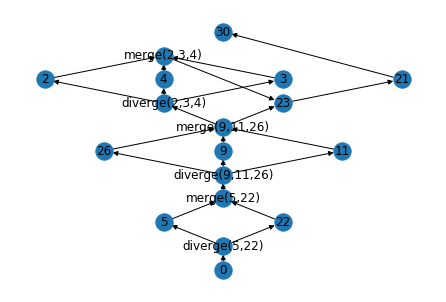

In [7]:
draw_wf(wf_cons)

In [16]:
# model_name = 'data_dir={}_version={}'.format(file_dir, version)
# model_name = 'softmax_data_dir=data_official_version=v0.0'
model_name = 'data_dir=data_official_version=v0.3'
if os.path.exists(model_dir + '/' + model_name + '.pt'):
    model.load_state_dict(torch.load(model_dir + '/' + model_name + '.pt'))
model.to(device)
model.eval()


Model(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=32, bias=True)
)

In [17]:
ts = 0.006
wf_cons = workflow_constructor(model,1,ts = 0.003)
wf_cons.workflow_construction([0],{30})
print(wf_cons.graph)

当前序列为: [0] 下一个可能出现event为: [22, 5]
判断分支情况 [22, 5]
发现不同的分支 [[22, 5]]
并发执行的分支 [22, 5]
发现循环 [5]
当前序列为: [22, 5] 下一个可能出现event为: [9, 26, 11]
判断分支情况 [9, 26, 11]
发现不同的分支 [[9, 26, 11]]
并发执行的分支 [9, 26, 11]
发现循环 [9]
发现循环 [26]
发现循环 [11]
当前序列为: [9, 26, 11] 下一个可能出现event为: [2, 3, 4, 23, 30]
判断分支情况 [2, 3, 4, 23, 30]
发现不同的分支 [[2, 3, 4], [23]]
并发执行的分支 [2, 3, 4]
发现循环 [2]
发现循环 [3]
发现循环 [4]
当前序列为: [2, 3, 4] 下一个可能出现event为: [23]
判断分支情况 [23]
发现不同的分支 [[23]]
当前序列为: [23] 下一个可能出现event为: [21]
当前序列中存在循环结构 [23]
判断分支情况 [21]
发现不同的分支 [[21]]
当前序列为: [21] 下一个可能出现event为: [30]
到达终止位置,结束 {30}
当前序列为: [23] 下一个可能出现event为: []
到达终止位置,结束 {30}
{'0': {'diverge(5,22)'}, 'diverge(5,22)': {'5', '22'}, '22': {'merge(5,22)'}, '5': {'5', 'merge(5,22)'}, 'merge(5,22)': {'diverge(9,11,26)'}, 'diverge(9,11,26)': {'26', '9', '11'}, '9': {'9', 'merge(9,11,26)'}, '26': {'26', 'merge(9,11,26)'}, '11': {'11', 'merge(9,11,26)'}, 'merge(9,11,26)': {'diverge(2,3,4)', '23'}, 'diverge(2,3,4)': {'2', '4', '3'}, '2': {'2', 'merge(2,3,4)'}, '3': {'merge(2

0 1 (0, 2)
0 2 (-0.5, 3)
1 2 (0.5, 3)
0 1 (0, 4)
0 1 (0, 5)
0 3 (-1, 6)
1 3 (0, 6)
2 3 (1, 6)
1 1 (0, 7)
0 2 (-0.5, 8)
1 2 (0.5, 8)
0 4 (-1.5, 9)
1 4 (-0.5, 9)
2 4 (0.5, 9)
1 2 (-0.5, 10)
0 4 (1.5, 9)
0 2 (0.5, 10)


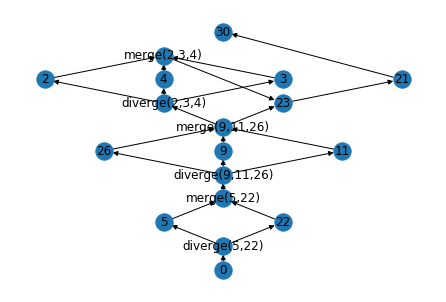

In [15]:
draw_wf(wf_cons)

In [33]:
_,pre,out=wf_cons.generate_seq([3,4,3,2,4,3,23,23,23,21],1,3)

In [21]:
softmax = nn.Softmax(dim=0)

In [34]:
softmax(out)[20]

tensor(0.0004, grad_fn=<SelectBackward>)

In [24]:
pre

tensor([ 4, 26, 25, 20,  6,  9,  5, 11, 30, 21])